
## Autoregressive Integrated Moving Averages (ARIMA)

and 


## Seasonal Autoregressive Integrated Moving Averages (SARIMA)



In [56]:
import numpy as np
from scipy import stats
import pandas as pd

import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas.plotting import lag_plot
from statsmodels.graphics.api import qqplot
%matplotlib inline

from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
import itertools
from statsmodels.tsa.arima_model import ARIMA

import config

from sklearn.metrics import mean_squared_error,mean_squared_log_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

In [57]:
df=pd.read_csv(config.MISSING_VALUE_HANDLED)
df=df.sort_values(by='Date') 
df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017208,1115,d,c,5350.0,8.0,2010.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2,2013-01-01,0,0,0,0,a,1
679363,746,d,c,4330.0,2.0,2011.0,1,35.0,2011.0,"Mar,Jun,Sept,Dec",2,2013-01-01,0,0,0,0,a,1
155193,171,a,a,2640.0,8.0,2010.0,0,0.0,0.0,0,2,2013-01-01,0,0,0,0,a,1
632403,694,a,c,460.0,11.0,2012.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct",2,2013-01-01,0,0,0,0,a,1
361623,396,a,c,23130.0,8.0,2010.0,0,0.0,0.0,0,2,2013-01-01,0,0,0,0,a,1


In [58]:
df.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
dtype: object

In [59]:
df= df[df['Store'] == 2]
df=df[["Date","Sales"]]
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df.head()

,Sales
Date,
2013-01-01,0
2013-01-02,4422
2013-01-03,4159
2013-01-04,4484
2013-01-05,2342


In [60]:
df.describe()

,Sales
count,942.000000
mean,4122.991507
std,2363.628674
min,0.000000
25%,2806.750000
50%,4395.500000
75%,5804.500000
max,10682.000000


<AxesSubplot:xlabel='Date'>

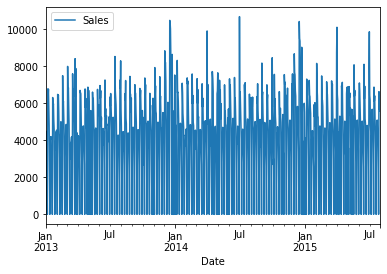

In [61]:
df.plot()

<AxesSubplot:xlabel='Date'>

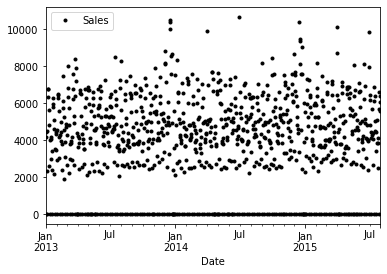

In [62]:
df.plot(style='k.')

In [63]:
df.shape

(942, 1)

array([[<AxesSubplot:title={'center':'Sales'}>]], dtype=object)

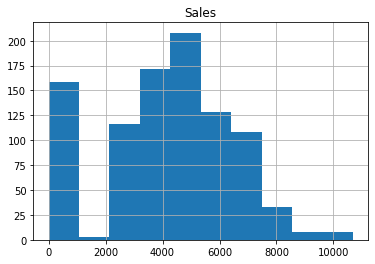

In [64]:
df.hist()

<AxesSubplot:ylabel='Density'>

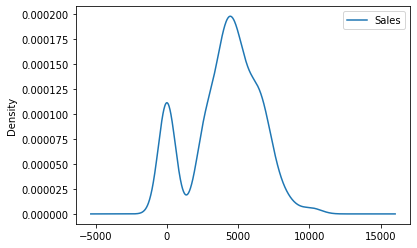

In [65]:
df.plot(kind='kde')

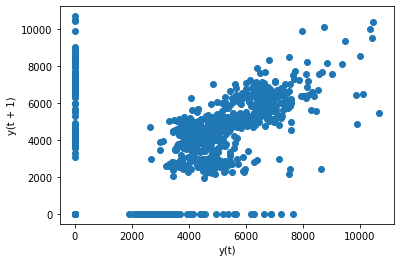

In [66]:
lag_plot(df)
plt.show()

In [67]:
# smoothing
moving_average_df=df.rolling(window=20).mean()  
moving_average_df

,Sales
Date,
2013-01-01,NaN
2013-01-02,NaN
2013-01-03,NaN
2013-01-04,NaN
2013-01-05,NaN
...,...
2015-07-27,3984.15
2015-07-28,3983.90
2015-07-29,4099.90


<AxesSubplot:xlabel='Date'>

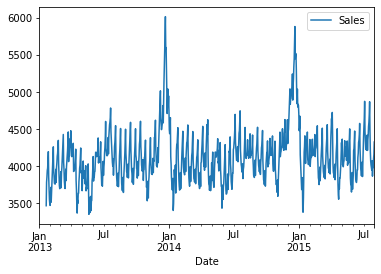

In [68]:
moving_average_df.plot()

In [69]:
sm.stats.durbin_watson(df) # correlation

array([0.39158623])

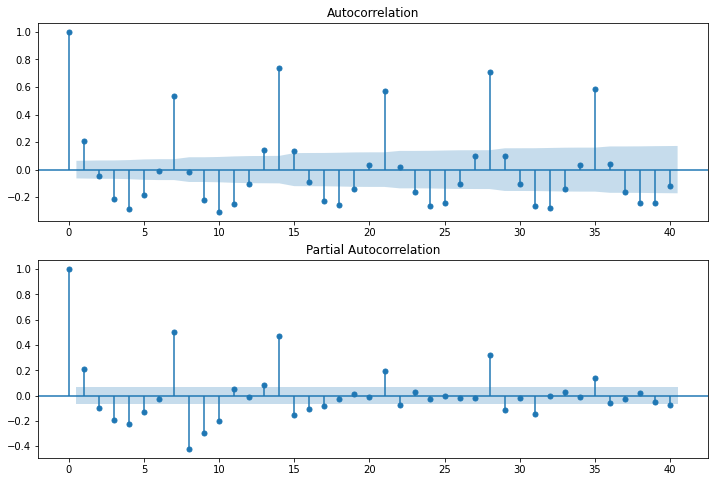

In [70]:
# acf and pacf plots
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df, lags=40, ax=ax2)

In [71]:
# Test for stationarity

test_result=adfuller(df['Sales'])
test_result

#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    print('Critical Values:')
    for key, value in result[4].items():
        print(key, value)
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    
adfuller_test(df['Sales'])

ADF Test Statistic : -6.36902376378052
p-value : 2.3702948948657072e-08
#Lags Used : 21
Number of Observations Used : 920
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [84]:
#test data 2015-07-01 to 2015-07-31
training_data,test_data=df[df.index<'2015-07-01'],df[df.index>='2015-07-01']

In [85]:
print(df.shape)
print(training_data.shape)
print(test_data.shape)

(942, 1)
(911, 1)
(31, 1)


In [86]:
# ARIMA
arima= ARIMA(training_data,order=(1,1,1))
model=arima.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  910
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -8347.739
Method:                       css-mle   S.D. of innovations           2323.660
Date:                Sun, 18 Oct 2020   AIC                          16703.478
Time:                        00:58:41   BIC                          16722.731
Sample:                    01-02-2013   HQIC                         16710.829
                         - 06-30-2015                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3170      0.368      0.860      0.390      -0.405       1.039
ar.L1.D.Sales     0.2061      0.033      6.320      0.000       0.142       0.270
ma.L1.D.Sales    -1.0000      0.003   -355.436      0.000      -1.005      -0.994
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            4.8520           +0.0000j            4.8520            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [87]:
model.aic

16703.47766038181

<AxesSubplot:xlabel='Date'>

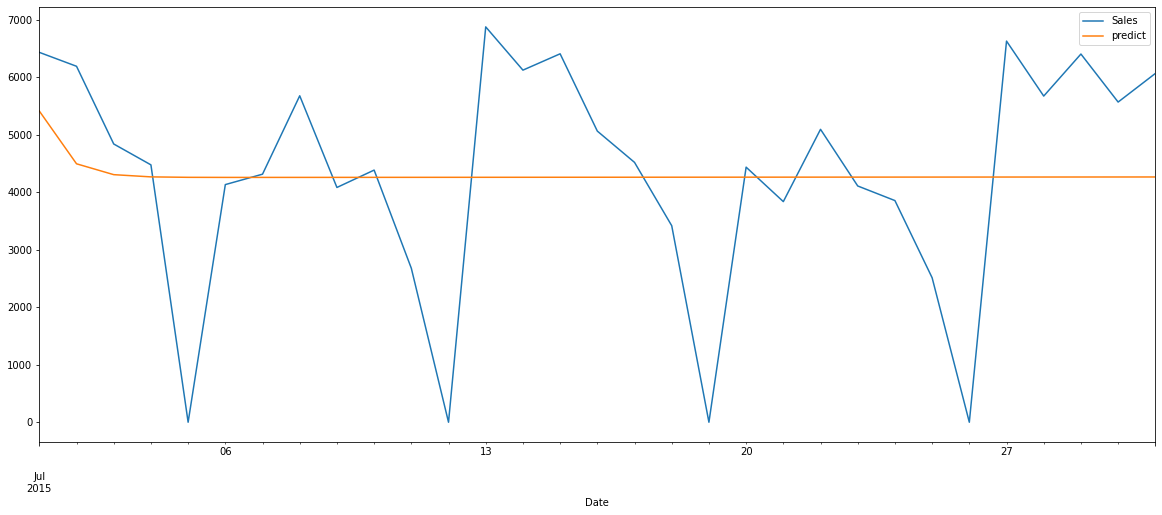

In [89]:
pred= model.forecast(steps=31)[0]
test_data['predict']=pred
test_data[['Sales','predict']].plot(figsize=(20,8))

In [90]:
# SARIMA
p = d = q = range(0, 2) # Define the p, d and q parameters to take any value between 0 and 2

pdq = list(itertools.product(p, d, q)) # Generate all different combinations of p, q and q triplets

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [91]:
model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  942
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -8542.384
Date:                            Sun, 18 Oct 2020   AIC                          17094.768
Time:                                    00:59:17   BIC                          17118.939
Sample:                                01-01-2013   HQIC                         17103.988
                                     - 07-31-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2021      0.030      6.667      0.000       0.143       0.262
ma.L1         -1.0000      0.622     -1.608      0.108      -2.219       0.219
ar.S.L12      -0.0854      0.045     -1.909      0.056      -0.173       0.002
ma.S.L12      -0.9991      0.624     -1.601      0.109      -2.222       0.224
sigma2      5.344e+06   1.16e-07   4.59e+13      0.000    5.34e+06    5.34e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 0.18
Prob(Q):                              0.78   Prob(JB):                         0.92
Heteroskedasticity (H):               1.15   Skew:                            -0.02
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.73e+29. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='Date'>

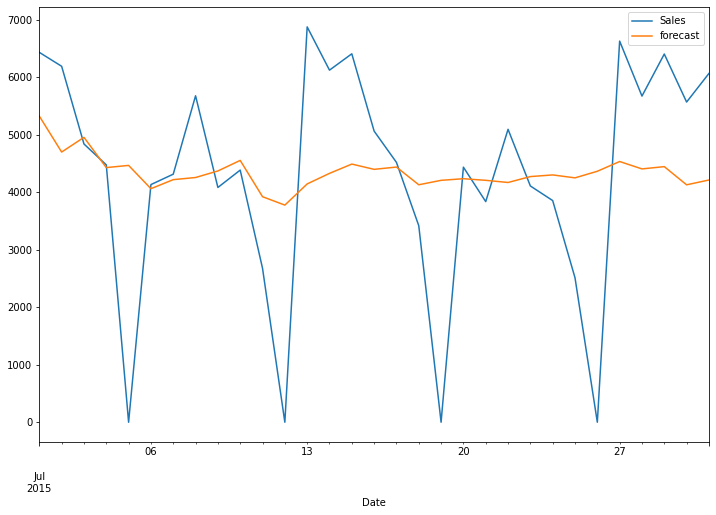

In [92]:
test_data['forecast']=results.predict(start=-31,dynamic=True)
test_data[['Sales','forecast']].plot(figsize=(12,8))

In [93]:
test_data

,Sales,predict,forecast
Date,,,
2015-07-01,6431,5410.821600,5322.614527
2015-07-02,6189,4493.472542,4697.906537
2015-07-03,4838,4304.657158,4953.533069
2015-07-04,4475,4265.993667,4427.607370
2015-07-05,0,4258.276708,4465.579163
2015-07-06,4132,4256.937877,4060.719286
2015-07-07,4313,4256.913587,4217.757190
2015-07-08,5676,4257.160225,4255.101752
2015-07-09,4082,4257.462703,4369.021113


In [99]:
print("RMSE =",np.sqrt(mean_squared_error(test_data['Sales'], test_data['predict'])))

RMSE = 1959.1596442142804
